In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from datetime import datetime
import os

from sklearn.model_selection import train_test_split

Num GPUs Available:  1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
z_max = 2.5

In [4]:
train_set = pd.read_csv('/data/HSC/HSC_v6/3_model_comparison/training_'+str(z_max)+'z_.csv')

In [5]:
train_array = np.asarray(train_set)

In [6]:
n = len(train_array) # number of galaxies

In [7]:
train_sorted = sorted(train_array, key=lambda x: x[2]) # sorted by 'specz_redshift'

In [8]:
train_sorted[0]

array([41601547150321034, 9.99999975e-06, 0.0100999996, 16.9960003,
       'SDSS-DR12-1237656906348626261', 345.33543, -0.925957, True,
       345.33555992089055, -0.9259759774764964,
       '(199519.6875, -52210.6796875, -3333.368408203125)', 94590303,
       22.2296257, 21.982687, 22.1828537, 23.84021, 23.0793934,
       0.00695806509, 0.00607395219, 0.00986235403, 0.0989359617,
       0.113840707], dtype=object)

In [9]:
# stratification of training set
nstrata = 4
stratas = []
cur = z_max/nstrata
pre = 0
for i in range(0, n):
    if train_sorted[i][2] >= cur:
        stratas.append(train_sorted[pre:i])
        pre = i
        cur += z_max/nstrata
    if i == n - 1:
        stratas.append(train_sorted[pre:i])
strata_lengths = []
# randomized to undo sorting
for i in range(0,nstrata):
    random.shuffle(stratas[i])
    strata_lengths.append(len(stratas[i]))
print(strata_lengths) # individual strata sizes

[157485, 50981, 8241, 7430]


In [10]:
nnetwork = 7 # networks in the ensemble minus 1 (6 networks)

In [11]:
sample_array = [1, 1, 1, 1] # proportionality configuration
training_set_size = 4 * min(strata_lengths) # total training size

In [12]:
training_set_size

29720

In [13]:
min_array = [int(training_set_size/sum(sample_array))] * nstrata

# Sets an array where the elements are the modified strata sizes
sample_size_array = [i*j for i,j in zip(sample_array, min_array)]

In [14]:
sample_size_array

[7430, 7430, 7430, 7430]

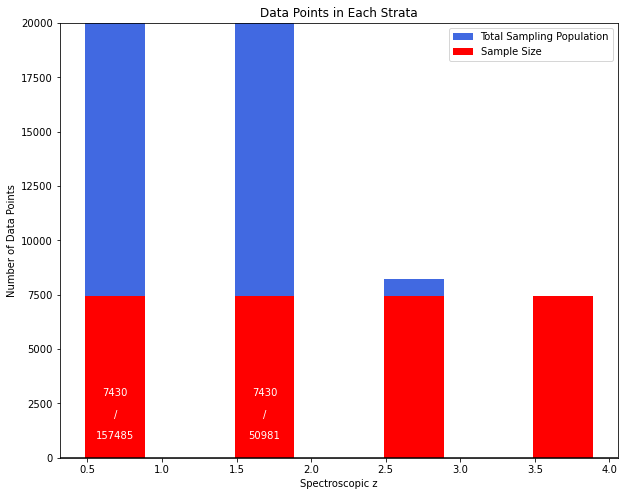

In [15]:
# Plot
z_ranges = [1, 2, 3, 4]
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 10})
ax = plt.subplot(111)
ax.bar([i-(z_max/nstrata/2) for i in z_ranges], strata_lengths, width = 0.4, color = 'royalblue', label = 'Total Sampling Population')
ax.bar([i-(z_max/nstrata/2) for i in z_ranges], sample_size_array, width = 0.4, color = 'red', label = 'Sample Size')

plt.title('Data Points in Each Strata')
plt.xlabel('Spectroscopic z')
plt.ylabel('Number of Data Points')
ylim = 20000
plt.ylim([0,ylim])
plt.text(z_ranges[0]-(z_max/nstrata/2), 1*ylim/20, str(strata_lengths[0]), color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 1*ylim/20, str(strata_lengths[1]), color = 'white', ha='center', va='center')
plt.text(z_ranges[0]-(z_max/nstrata/2), 2*ylim/20, "/", color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 2*ylim/20, "/", color = 'white', ha='center', va='center')
plt.text(z_ranges[0]-(z_max/nstrata/2), 3*ylim/20, str(sample_size_array[0]), color = 'white', ha='center', va='center')
plt.text(z_ranges[1]-(z_max/nstrata/2), 3*ylim/20, str(sample_size_array[1]), color = 'white', ha='center', va='center')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend()
plt.axhline(y=0, color='black', linestyle='-')
plt.show()

In [16]:
# Sampling training data from each strata

training_data = []

for i in range(0, nnetwork):
    sampled = random.sample(stratas[0][0:strata_lengths[0]], sample_size_array[0])
    training_data_bin = sampled
    for j in range(1, nstrata):
        sampled = random.sample(stratas[j][0:strata_lengths[j]], sample_size_array[j])
        training_data_bin = np.concatenate((training_data_bin, sampled), axis=0)
    training_data.append(training_data_bin)

In [17]:
for i in range(1, nnetwork + 1):
    df = pd.DataFrame(training_data[i - 1], columns=['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'])
    #df.to_csv('/data/HSC/HSC_v6/3_model_comparison/undersampled_training_set_'+str(z_max)+'z_'+str(sample_array)+'#'+str(i)+'.csv', index=False)

In [18]:
len(training_data[0])

29720

In [19]:
# END

In [20]:
df # TOTAL TRANING SIZE FOR UNDERSAMPLED

,object_id,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec,specz_flag_homogeneous,ra,dec,...,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma
0,41223452589320133,0.00065,0.29622,18.816,GAMA-DR2-544975,217.77646,-0.96679,True,217.776473,-0.966794,...,21.37532,19.853359,19.213608,18.897217,18.622095,0.003129,0.001747,0.00077,0.001153,0.001653
1,40994754170744145,0.00053,0.06886,18.431,GAMA-DR2-527985,140.66246,-0.84889,True,140.662474,-0.848878,...,19.091679,18.735397,18.389282,18.279377,18.123701,0.000834,0.000727,0.000475,0.000956,0.001135
2,43096625266058992,0.00061,0.21029,17.947001,GAMA-DR2-521609,129.98546,2.82199,True,129.985437,2.822002,...,19.465019,18.328716,17.821526,17.497536,17.327042,0.001347,0.001921,0.000505,0.00073,0.001012
3,69555543659774458,0.00003,0.11115,16.51,SDSS-DR12-1237661852552003718,213.07879,42.692332,True,213.078837,42.692345,...,18.069195,17.115177,16.622797,16.331631,16.182812,0.000925,0.000434,0.000575,0.000396,0.001116
4,41219200571709924,0.00065,0.3018,18.740999,GAMA-DR2-568719,216.13675,-0.48383,True,216.136758,-0.483808,...,20.220421,19.162338,18.594019,18.2799,18.103745,0.00164,0.000968,0.000578,0.00075,0.001207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29715,41592768237143965,0.00048,2.2981,20.313999,SDSS-DR12-1237663478725935358,342.46859,-0.247912,True,342.468598,-0.247917,...,21.429459,21.259968,20.93734,20.595745,20.644394,0.0027,0.002655,0.001774,0.002413,0.004993
29716,40577098665954426,0.00041,2.36452,19.521999,SDSS-DR12-1237657190905151646,359.86318,-0.034698,True,359.863179,-0.034682,...,19.731751,19.663788,19.516369,19.379337,19.156746,0.001394,0.000947,0.001016,0.001194,0.00193
29717,69625487202217794,0.00046,2.35029,20.552999,SDSS-DR12-1237659327101862449,245.58134,42.231459,True,245.581343,42.231462,...,20.713573,20.758837,20.787865,20.651333,20.534716,0.002559,0.00226,0.00185,0.005426,0.006962
29718,42182106469656752,0.00045,2.15169,21.348,SDSS-DR12-1237648722841764169,180.90524,1.253403,True,180.90521,1.253422,...,22.062429,22.171951,22.043205,21.726603,21.909,0.003892,0.00484,0.004932,0.00725,0.021934
